In [ ]:
## 1. Setup & Imports

# Core
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, warnings
from tqdm import tqdm

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [6]:
# Config
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
nltk.download(['punkt', 'stopwords', 'wordnet', 'punkt_tab'], quiet=True)

True

In [ ]:
## 2. Load & Explore Data

df = pd.read_json('reviews.jl', lines=True)

print(f"Shape: {df.shape}")
print(f"Missing: {df.isnull().sum().sum()} | Duplicates: {df.duplicated().sum()}")
print(f"\nColumns:")
for col in df.columns:
    print(f"  • {col}")

print("\nPreview:")
df.head(2)

Shape: (5990, 5)
Missing: 7432 | Duplicates: 0

Columns:
  • review_id
  • rating
  • timestamp
  • title
  • body

Preview:


,review_id,rating,timestamp,title,body
0,969643a0-0957-4db9-ad1a-6e10cacd5a86,5,NaT,Comfy!,So comfy and the cut is so flattering. I love ...
1,e0b89f86-9b8e-507c-a271-adf89152bed8,5,NaT,None,Love it!!


In [10]:
#3. Data Cleaning
# Select relevant columns
df_work = df[['rating', 'title', 'body']].copy()
df_work.columns = ['rating', 'title', 'review']

In [13]:
# Handle missing values
print(f"Missing review titles=: {df_work['title'].isnull().sum()}")

print(f"Missing reviews: {df_work['review'].isnull().sum()}")
df_work = df_work.dropna(subset=['review'])
print(f"Clean dataset: {len(df_work)} rows")

Missing review titles=: 1442
Missing reviews: 0
Clean dataset: 5990 rows


In [14]:
# Rating distribution
print(f"Rating Distribution:")
print(df_work['rating'].value_counts().sort_index())

Rating Distribution:
rating
1      99
2     136
3     321
4     765
5    4669
Name: count, dtype: int64


In [15]:
df_work.head(2)

,rating,title,review
0,5,Comfy!,So comfy and the cut is so flattering. I love ...
1,5,None,Love it!!


In [16]:
# 4. Create Sentiment Labels
# Binary classification: Positive (4-5) = 1, Negative (1-2) = 0
df_work['sentiment'] = df_work['rating'].apply(
    lambda x: 1 if x >= 4 else (0 if x <= 2 else -1)
)

# Remove neutral (rating = 3)
df_binary = df_work[df_work['sentiment'] != -1].copy()

In [17]:
print(f"Original: {len(df_work)} | Binary dataset: {len(df_binary)}")
print(f"\nSentiment Distribution:")
print(df_binary['sentiment'].value_counts().rename({1: 'Positive', 0: 'Negative'}))

Original: 5990 | Binary dataset: 5669

Sentiment Distribution:
sentiment
Positive    5434
Negative     235
Name: count, dtype: int64


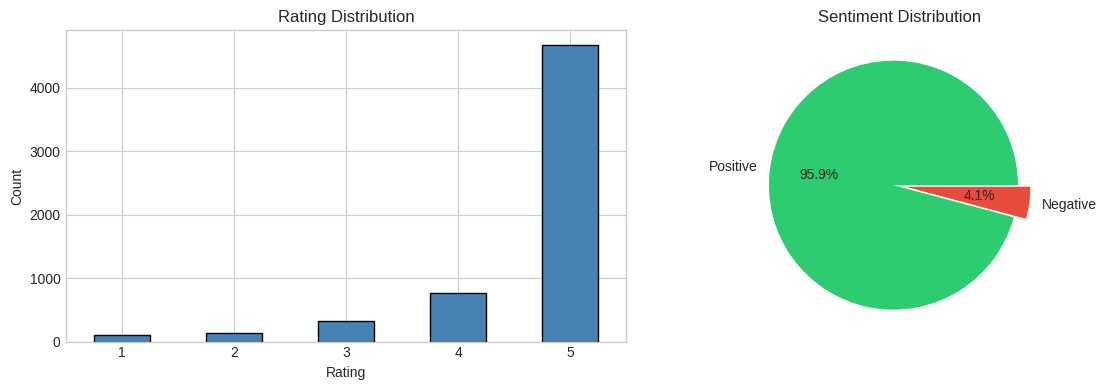

In [ ]:
## 5. Exploratory Data Analysis (EDA)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Rating distribution
df_work['rating'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Count')
axes[0].tick_params(rotation=0)

# Sentiment distribution
df_binary['sentiment'].value_counts().plot(kind='pie', ax=axes[1], labels=['Positive', 'Negative'],
    autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'], explode=(0.05, 0.05))
axes[1].set_title('Sentiment Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

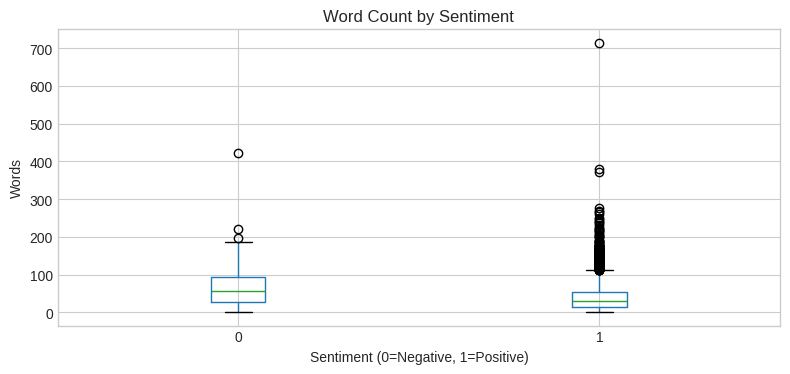

Average word count:
sentiment
Negative    67.727660
Positive    39.870445
Name: word_count, dtype: float64


In [19]:
# Review length analysis
df_binary['word_count'] = df_binary['review'].apply(lambda x: len(str(x).split()))

fig, ax = plt.subplots(figsize=(8, 4))
df_binary.boxplot(column='word_count', by='sentiment', ax=ax)
ax.set_title('Word Count by Sentiment')
ax.set_xlabel('Sentiment (0=Negative, 1=Positive)')
ax.set_ylabel('Words')
plt.suptitle('')
plt.tight_layout()
plt.show()

print("Average word count:")
print(df_binary.groupby('sentiment')['word_count'].mean().rename({0: 'Negative', 1: 'Positive'}))

In [20]:
## 6. Text Preprocessing

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|<.*?>|\d+', '', text)  # URLs, HTML, numbers
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    return ' '.join(tokens)


In [21]:
# Preview
sample = "This product is AMAZING!!! Check http://example.com <br> 5 stars!"
print(f"Before: {sample}")
print(f"After: {preprocess_text(sample)}")

Before: This product is AMAZING!!! Check http://example.com <br> 5 stars!
After: product amazing check star


In [22]:
# Apply preprocessing
tqdm.pandas(desc="Cleaning")
df_binary['cleaned_review'] = df_binary['review'].progress_apply(preprocess_text)

Cleaning: 100%|██████████| 5669/5669 [00:00<00:00, 7596.82it/s]


In [23]:
# Remove empty reviews
df_binary = df_binary[df_binary['cleaned_review'].str.strip() != '']
print(f"\nFinal dataset: {len(df_binary)} reviews")


Final dataset: 5662 reviews


In [24]:
df_binary[['review', 'cleaned_review', 'sentiment']].head(2)

,review,cleaned_review,sentiment
0,So comfy and the cut is so flattering. I love ...,comfy cut flattering love cropped design got m...,1
1,Love it!!,love,1


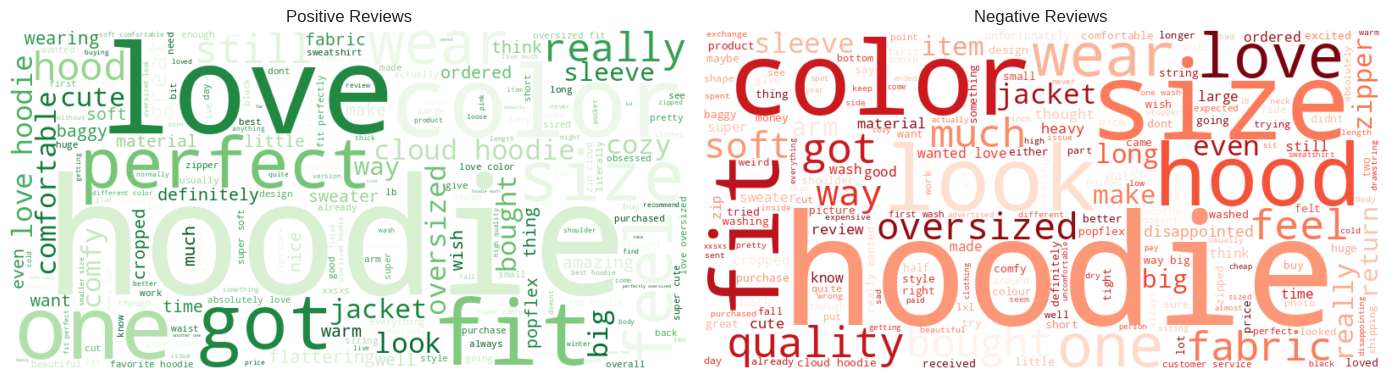

In [26]:
# 7. Word Cloud Visualization

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Positive
positive_text = ' '.join(df_binary[df_binary['sentiment'] == 1]['cleaned_review'])
wc_pos = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
axes[0].imshow(wc_pos, interpolation='bilinear')
axes[0].set_title('Positive Reviews')
axes[0].axis('off')

# Negative
negative_text = ' '.join(df_binary[df_binary['sentiment'] == 0]['cleaned_review'])
wc_neg = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)
axes[1].imshow(wc_neg, interpolation='bilinear')
axes[1].set_title('Negative Reviews')
axes[1].axis('off')

plt.tight_layout()
plt.show()

This sentiment analysis is adapted from https://www.kaggle.com/code/devbhandari00/amazon-reviews-sentiment-analysis. The rest is my work